In [15]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import numpy as np
import itertools
from math import pi
import time
import matplotlib.pyplot as plt
import h5py

This notebook details the tools relevant to continuation, namely ```dimension_continuation``` and ```discretization_continuation```.

In [16]:
s = 'C:/Users/Matt/Desktop/other/gudorf_gatech_repo/gudorf/KS/python/data_and_figures/tiles/streak/final_tile/EquilibriumOrbitKS_L6p39.h5'
w = 'C:/Users/Matt/Desktop/other/gudorf_gatech_repo/gudorf/KS/python/data_and_figures/tiles/gap/final_tile/AntisymmetricOrbitKS_T17p150_L17p591.h5'
m = 'C:/Users/Matt/Desktop/other/gudorf_gatech_repo/gudorf/KS/python/data_and_figures/tiles/defects/defect1/final_tile/RelativeOrbitKS_T15p855_L13p026.h5'

with h5py.File(m, 'r+') as file:
    dat = file['field'][...]
    params = tuple(file['parameters'][...])
    m = RelativeOrbitKS(state=dat, parameters=params, basis='field')

with h5py.File(w, 'r+') as file:
    dat = file['field'][...]
    params = tuple(file['parameters'][...])
    w = AntisymmetricOrbitKS(state=dat, parameters=params, basis='field')

with h5py.File(s, 'r+') as file:
    dat = file['field'][...]
    params = tuple(file['parameters'][...])
    s = EquilibriumOrbitKS(state=dat, parameters=params, basis='field')
    
d = read_h5('../../data/local/thesis.h5', 'families/defect_large_family_member').transform(to='modes')

In [18]:
td = read_tileset('../../data/ks/tiles.h5', (0, 1, 2),
                  ('/default/double_streak','/default/defect','/default/wiggle'),
                  validate=False)
td[0].plot()
td[1].plot()
td[2].plot()
# td[0] = td[0].cell_shift(4, axis=1)

tile(np.array([[1],[0]]), td, OrbitKS).plot()

orbit_1_2 = tile(np.array([[1],[0]]), td, OrbitKS)  
orbit_1_2.plot()
result_12 = hunt(orbit_1_2.resize(8, 8).resize(16, 16).transform(to='modes'), 
                     method='hybrid', verbose=True, pexp=(1,4), preconditioning=True, comp_time='long')

1.8825457676874493e-14

In [10]:
td = read_fpo_set(tileset='resized', rescaled=True)
streak = td[0]
defect = td[1]
wiggle = td[2]

NameError: name 'read_fpo_set' is not defined

The first type of continuation is ```dimension_continuation``` which imposes constraints on the dimensions, performing
a multi-stepped optimization process. To demonstrate this, the 'defect' fundamental periodic orbit is converted back into
a RelativeOrbitKS; it was saved as an OrbitKS without symmetry because of how tiling works. 

In [4]:
defect = convert_class(td[1], RelativeOrbitKS).reshape(16,16).transform(to='modes')
defect = converge(defect, method='lstsq', verbose=True).orbit


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial residual : 38.27588459011695
Target residual tolerance : 2.56e-07
Maximum iteration number : 250
Initial guess : RelativeOrbitKS({"basis": "modes", "parameters": ["17.1508", "13.0196", "3.235"], "field_shape": ["16", "16"]})
-------------------------------------------------------------------------------------------------
#######
Converged. Exiting with residual 1.2941286777876588e-08


The first demonstration is that temporal continuation, fixing the temporal period, can be used instead of spatial continuation
which is less likely to succeed, *if* the temporal period corresponding to the spatial size is known. For example, let's say that we are targeting $L=13.08$ for the defect tile.


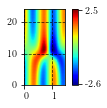

In [5]:
defect.plot()

In [6]:
defect_spatial_continuation = dimension_continuation(defect, 13.08, step_size=0.025, axis=1, method='lstsq', verbose=True).orbit


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial residual : 0.00644652998093617
Target residual tolerance : 2.56e-07
Maximum iteration number : 250
Initial guess : RelativeOrbitKS({"basis": "modes", "parameters": ["24.3596", "12.9602", "3.2401"], "field_shape": ["16", "16"]})
-------------------------------------------------------------------------------------------------
##
Converged. Exiting with residual 1.246529749283497e-11

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial residual : 0.006699656441405508
Target residual tolerance : 2.56e-07
Maximum iteration number : 250
Initial guess : RelativeOrbitKS({"basis": "modes", "parameters": ["23.3015", "12.9852", "3.2484"], "field_shape": ["16", "16"]})
-------------------------------------------------------------------------------------------------
##
Converged. Exiti

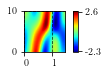

RelativeOrbitKS({"basis": "modes", "parameters": ["10.1105", "13.08", "3.7036"], "field_shape": ["16", "16"]})

In [7]:
defect_spatial_continuation.plot()
defect_spatial_continuation

This can also be performed in time to the same domain size, in order to achieve the approximately same orbit.

In [8]:
defect_spatial_continuation.T

10.110505916382113

In [9]:
defect.constraints

{'T': False, 'L': False, 'S': False}

In [10]:
defect_temporal_continuation = dimension_continuation(defect, defect_spatial_continuation.T, step_size=8, axis=0,
                                                      method='lstsq', verbose=True).orbit


-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial residual : 1.6511730398718558
Target residual tolerance : 2.56e-07
Maximum iteration number : 250
Initial guess : RelativeOrbitKS({"basis": "modes", "parameters": ["16.3596", "12.9352", "3.2401"], "field_shape": ["16", "16"]})
-------------------------------------------------------------------------------------------------
###
Converged. Exiting with residual 2.68313130292864e-12

-------------------------------------------------------------------------------------------------
Starting lstsq optimization
Initial residual : 4.14890778261684
Target residual tolerance : 2.56e-07
Maximum iteration number : 250
Initial guess : RelativeOrbitKS({"basis": "modes", "parameters": ["10.1105", "13.0238", "3.3303"], "field_shape": ["16", "16"]})
-------------------------------------------------------------------------------------------------
####
Converged. Exiting 

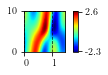

In [11]:
defect_temporal_continuation.plot()

It can also be useful to rediscretize and converge the result; this is accessible through ```discretization_continuation```;
provide the new field_shape and then the function will try to increment the discretization size by the specified amount;
the routine will always reshape in the most optimized manner, i.e. the smallest dimensions first.

if going from (16, 16)-> (32, 64), the shape goes to (16, 64) and then (32, 64) unless `cycle=True`, at which point discretization will cycle through the axes in order specified by the user via `axes_order` keyword argument.

For example: `axes_order=(1, 0)`, `initial_shape = (16, 16)`, `target_shape = (32, 64)` would rediscretize in sequence
(16, 18)->(18,18)->(18,20)-> ... -> (32, 64)

If, of course, the increment is specified to be 2 in each dimension.

In [12]:
x = discretization_continuation(defect_temporal_continuation, (24, 24), step_sizes=(2,2), cycle=True, verbose=True)


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial residual : 0.11133567034669802
Target residual tolerance : 2.8800000000000004e-07
Maximum iteration number : 4608
Initial guess : RelativeOrbitKS({"basis": "modes", "parameters": ["10.1105", "13.08", "3.7036"], "field_shape": ["16", "18"]})
-------------------------------------------------------------------------------------------------

Converged. Exiting with residual 4.556904046919726e-07

-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial residual : 1.901436568879923e-06
Target residual tolerance : 3.2400000000000004e-07
Maximum iteration number : 5184
Initial guess : RelativeOrbitKS({"basis": "modes", "parameters": ["10.1105", "13.08", "3.7036"], "field_shape": ["18", "18"]})
-------------------------------------------------------------------------------------------------


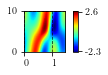

In [13]:
x.orbit.plot()

This is also automated through the ```span_family``` function. This function requires bounds, step_sizes, and the orbit to serve as the "root" of the branches.

In [ ]:
keys = tuple(['defect', 'larger_defect', 'streak', 'wiggle'])
# keys = tuple(['streak', 'wiggle'])
names = tuple(['/default/'+k for k in keys])
root_orbits = read_tileset('../../data/ks/tiles.h5', keys, names)

drifter = continuation(root_orbits['defect'].transform(to='modes').resize(32, 32), {'x':13.2}, verbose=False, method='lstsq')
root_orbits['drifter']=drifter

root_orbits['larger_defect'].transform(to='modes')

keys = tuple(['defect', 'larger_defect', 'streak', 'wiggle'])
# keys = tuple(['streak', 'wiggle'])
names = tuple(['/default/'+k for k in keys])
root_orbits = read_tileset('../../data/ks/tiles.h5', keys, names)
orb = hunt(root_orbits['larger_defect'].transform(to='modes').resize(32, 32), method='lstsq').orbit
bounds = {'x': (orb.x-0.5, orb.x+0.5)}
step_sizes = {'x': 0.001}
span_family(orb, bounds=bounds, step_sizes=step_sizes,
            verbose=True, method='hybrid', hybrid_tol=(1e-9, 1e-9), filename='larger_defect.h5')

for root in root_orbits:
    orb = root_orbits[root].transform(to='modes').resize(16, 16)
    bounds = {'t': (orb.t-2, orb.t+2), 'x': (orb.x-1, orb.x+1)}
    step_sizes = {'t': 0.1, 'x': 0.02}
    span_family(orb, bounds=bounds, step_sizes=step_sizes,
                verbose=True, method='hybrid', hybrid_tol=(1e-2, 1e-5), filename='covering.h5', groupname=root, h5mode='a')

import orbithunter.ks.physics as ks
covering_orbits = read_h5('../../data/local/covering.h5')
for i in range(len(covering_orbits)):
    covering_orbits[i] = sorted(covering_orbits[i], key=lambda x : x.x)
    
small_covering = [covering_orbits[0][62], covering_orbits[0][67],
                  covering_orbits[2][30], covering_orbits[-1][45]]

for i in range(len(small_covering)):
    small_covering[i] = hunt(small_covering[i].resize(32,32),verbose=True, method='lstsq').orbit
    print(small_covering[i] .discretization, small_covering[i].residual())
    small_covering[i].plot()

small_covering_names = ['defect', 'smeared_defect', 'wide_defect', 'wiggle']
for n, x in zip(small_covering_names, small_covering):
    x.to_h5(filename='small_covering.h5', verbose=True, dataname=n, h5mode='a')

small_covering = read_h5('small_covering.h5')

for x in small_covering:
    x.plot()

To get the most "accurate" possible results for the statistics, make sure that each trajectory window has approximately
the same grid spacing as the windows. 

integrated_trajectory_segment = read_h5('large_trajectories.h5', '/1319/').resize(512, 512)

for i in range(1):
    integrated_trajectory_tmp = ks.physics.integrate(integrated_trajectory_segment, integration_time=500, verbose=True,
                                              starting_point=0, step_size=0.25, return_trajectory=False)
    print('          ', end='')
    integrated_trajectory_segment = ks.physics.integrate(integrated_trajectory_tmp, integration_time=500, verbose=True,
                                              starting_point=0, step_size=0.25, return_trajectory=True)
    print('')
    tmp = integrated_trajectory_segment.resize(512, 512).transform(to='field')
    tmp.to_h5('large_trajectories.h5', verbose=True)
#     print('#',end='')
#     if i % 50 == 0 and i != 0:
#         print('#')
#     for gname, o in zip(small_covering_names, small_covering):
#         dt = integrated_trajectory_segment.t / 512
#         dx = integrated_trajectory_segment.x / 512
#         tspan, xspan = 2*(int(o.t/dt)//2), 2*(int(o.x/dx)//2)
#         t, x = np.random.choice(np.arange(512-tspan)), np.random.choice(np.arange(512-xspan))
#         state = tmp.state[t:t+tspan, x:x+xspan]
#         tmp_orbit = OrbitKS(state=state, parameters=(tspan*dt, xspan*dx), basis='field')
#         tmp_orbit.to_h5(filename='trajectory_windows.h5', groupname=gname, verbose=False)

Produce and save the (large) number of data sets to use for statistics gathering. Save every OTHER segment to (hopefully) take care of correlations. 



integrated_trajectory_segment = read_h5('../../data/local/thesis.h5', 'large/OrbitKS_large_tL').resize(512, 512)
small_covering_names = ['defect', 'smeared_defect', 'wide_defect', 'wiggle']

for i in range(1000):
    integrated_trajectory_tmp = ks.integrate(integrated_trajectory_segment, integration_time=500, verbose=True,
                                              starting_point=0, step_size=0.25, return_trajectory=False)
    print('')
    integrated_trajectory_segment = ks.integrate(integrated_trajectory_tmp, integration_time=500, verbose=True,
                                              starting_point=0, step_size=0.25, return_trajectory=True)
    print('')
    tmp = integrated_trajectory_segment.resize(512, 512).transform(to='field')

Window statistics. Would like to leverage the central limit theorem but diff members have diff distributions. 

id(OrbitKS)

import orbithunter.ks as ks

integrated_trajectory_segment.resize(512, 512)

base = integrated_trajectory_segment.copy()

strides = (1, 1)
group_orbit_masks = []
covering_scores = []

window = small_covering[0].resize(16, 16).transform(to='field')
group_orbit_scores = []
for g in window.group_orbit():
    print('#', end='')
    scores = scan(base, g, strides=(4, 4))
    group_orbit_scores.append(scores)
covering_scores = np.array(group_orbit_scores)#.reshape()

plt.hist(covering_scores.ravel(), bins=100)
plt.show()

See if these scores seem like they come from the same distribution. 

statistics = []
for i in range(len(num_large_trajectories)):
    # While I would rather iterate over fpo's as the outer loop, that would result in 4 times as many loadings.
    integrated_trajectory_segment = read_h5('large_trajectories.h5', str(i))
    statistics_per_fpo = []
    for fpo in small_covering:
        group_orbit_statistics = []
        dt = integrated_trajectory_segment.t / 512
        dx = integrated_trajectory_segment.x / 512
        tspan, xspan = 2*(int(o.t/dt)//2), 2*(int(o.x/dx)//2)
        t, x = np.random.choice(np.arange(512-tspan)), np.random.choice(np.arange(512-xspan))
        state = tmp.state[t:t+tspan, x:x+xspan]
        tmp_orbit = OrbitKS(state=state, parameters=(tspan*dt, xspan*dx), basis='field')
        for g_fpo in fpo.group_orbit():
            amp_difference = (tmp_orbit**2 - fpo**2).norm()
            group_orbit_statistics.append(amp_difference)
        statistics_per_fpo.append(group_orbit_statistics)
    statistics.append(statistics_per_fpo)


In order to get well-defined values to threshold with, develop distributions of the scoring statistic
for the covering orbits evaluated "randomly" along a large spatiotemporal trajectory. I.e. many correlation lengths
apart. To do this, integrate and then evaluate the scoring metric at a single position, then continue. This ensures the evaluations are very far apart.

# defect_large = read_h5('../../data/local/thesis.h5', 'families/defect_large_family_member').transform(to='modes')
# large_defect_minus_result = discretization_continuation(defect_large, (16, 16),
#                                                         cycle=True, method='lstsq', verbose=True)
# large_defect_minus_result.status = 1
# group_orbit_generator = large_defect_minus_result.orbit.group_orbit()
# try:
#     i = 1
#     while large_defect_minus_result.status != -1 and group_orbit_generator:
#         nxt_orbit = next(group_orbit_generator)
#         print('{}th group orbit member'.format(i))
#         large_defect_minus_result = continuation(nxt_orbit.transform(to='modes'), nxt_orbit.t-5, 't',
#                                                  verbose=False, step_size=-0.01, method='lstsq', tol=1e-6,
#                                                  filename='../../data/local/covering.h5')
#         i+=1
# except StopIteration:
#     print('group orbit exhausted before continuation target met.')
# large_defect_minus_result.orbit.plot()